<a href="https://colab.research.google.com/github/Gooogr/Keras_Fast_Style_Transfer/blob/master/5)_Fast_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import zipfile

import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

import numpy as np

from keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, \
                         Activation, ReLU, MaxPooling2D
from keras import layers
from keras.models import Model
from keras.applications import vgg16

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Data downloading

In [3]:
# show current dir
!pwd

/content


In [4]:
# download train part of COCO 2014 dataset to content folder
!wget http://images.cocodataset.org/zips/train2014.zip

--2019-12-18 15:03:21--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.128.59
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.128.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  52.9MB/s    in 4m 1s   

2019-12-18 15:07:22 (53.5 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [5]:
# create dir for dataset and extract zip file there
! mkdir coco2014_train
!ls

coco2014_train	drive  sample_data  train2014.zip


In [0]:
zip_file_path = '/content/train2014.zip'
dir_path = '/content/coco2014_train'

In [0]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dir_path)

In [0]:
unzipped_train_path = '/content/coco2014_train/train2014'

In [9]:
# create complete file pathes
files_path_list = [os.path.join(unzipped_train_path, file_name) for file_name in os.listdir(unzipped_train_path)]
files_path_list[:3]

['/content/coco2014_train/train2014/COCO_train2014_000000572110.jpg',
 '/content/coco2014_train/train2014/COCO_train2014_000000080336.jpg',
 '/content/coco2014_train/train2014/COCO_train2014_000000043854.jpg']

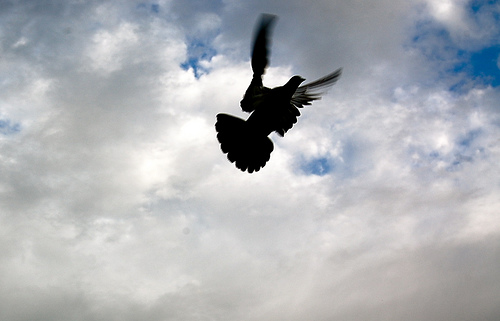

In [10]:
img_example = cv2.imread(files_path_list[np.random.randint(0, len(files_path_list))])
cv2_imshow(img_example)

### Setting up model utility functions

In [0]:
def preprocess_img(img_path):
  pass

In [0]:
def deprocess_img(img):
  pass

In [0]:
def gram_matrix(x):
    '''
    Вспомогательная функция. Вычисляет матрицу Грама для корреляционной матрицы.
    http://pmpu.ru/vf4/dets/gram
    '''
    # K.permute_dimensions - Permutes axes in a tensor. https://www.tensorflow.org/api_docs/python/tf/keras/backend/permute_dimensions
    # K.batch_flatten - Turn a nD tensor into a 2D tensor with same 0th dimension. https://www.tensorflow.org/api_docs/python/tf/keras/backend/batch_flatten
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [0]:
def get_content_loss(args):
  pass

In [0]:
def get_style_loss(batch_size):
  pass

In [0]:
def get_tv_loss(args):
  pass

### Setting up model architecture

In [0]:
def residual_block(y, _nb_channels = 128, _strides = (1, 1)):
  shortcut = y

  #forward pass
  y = Conv2D(filters = _nb_channels, kernel_size = (3, 3), 
             strides = _strides, padding = 'same')(y)
  y = BatchNormalization()(y)
  y = ReLU()(y)

  y = Conv2D(filters = _nb_channels, kernel_size = (3, 3), 
             strides = _strides, padding = 'same')(y)
  y = BatchNormalization()(y)

  #adding shortcut
  y = layers.add([shortcut, y])
  y = ReLU()(y)

  return y

![alt text](https://miro.medium.com/max/470/1*3-TqqkRQ4rWLOMX-gvkYwA.png)

In [0]:
##############TEMPORARY CONSTANTS#####################
height = 512 
width = 512
# batch_size = 1

In [45]:
model_input = Input(shape = (height, width, 3), name = 'model_input')

### Autoencoder block ###
# Convolution sub-blocks
c1 = Conv2D(32, (9, 9), strides = 1, padding = 'same', name = 'conv_1')(model_input)
c1 = BatchNormalization(name = 'norm_1')(c1)
c1 = ReLU(name = 'relu_1')(c1)

c2 = Conv2D(64, (3, 3), strides = 2, padding = 'same', name = 'conv_2')(c1)
c2 = BatchNormalization(name = 'norm_2')(c2)
c2 = ReLU(name = 'relu_2')(c2)

c3 = Conv2D(128, (3, 3), strides = 2, padding = 'same', name = 'conv_3')(c2)
c3 = BatchNormalization(name = 'norm_3')(c3)
c3 = ReLU(name = 'relu_3')(c3)

# Residual sub-blocks
r1 = residual_block(c3)
r2 = residual_block(r1)
r3 = residual_block(r2)
r4 = residual_block(r3)
r5 = residual_block(r4)

# Deconvolution sub-blocks
d1 = Conv2DTranspose(64, (3, 3), strides = 2, padding='same', name = 'conv_4')(r1)
d1 = BatchNormalization(name = 'norm_4')(d1)
d1 = ReLU(name = 'relu_4')(d1)

d2 = Conv2DTranspose(32, (3, 3), strides = 2, padding='same', name = 'conv_5')(r1)
d2 = BatchNormalization(name = 'norm_5')(d1)
d2 = ReLU(name = 'relu_5')(d1)

c4 = Conv2D(3, (9, 9), strides = 1, padding = 'same', name = 'conv_6')(d2)
c4 = BatchNormalization(name = 'norm_3')(c4)
c4 = Activation(activation = 'hard_sigmoid', name = 'hard_sigmoid_1')(c4) #hard sigmoid computes faster then sigmoid
# c4 = OutputScale()(c4)??? Нужно перегнать (256х256х3) -> (224x224x3) ?

### Content and style activation inputs
content_activation = Input(shape = (height//4, width//4, 256)) #shapes correspond to VGG16 layers

style_activation_1 = Input(shape = (height, width, 64))
style_activation_2 = Input(shape = (height//2, width//2, 128))
style_activation_3 = Input(shape = (height//4, width//4, 256))
style_activation_4 = Input(shape = (height//8, width//8, 512))

### VGG-16 block ###
# Sub-block 1
vgg_c1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'vgg_16_block1_conv1')(c4)
vgg_c1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'vgg_16_block1_conv2')(vgg_c1)
style_loss1 = layers.Lambda(get_style_loss, output_shape = (1,), name = 'style_loss1', 
                            arguments = {'batch_size': batch_size})([vgg_c1, style_activation_1])
vgg_c1 = MaxPooling2D((2, 2), strides = (2, 2), name = 'vgg_16_block1_pool')(vgg_c1)

# Sub-block 2
vgg_c2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'vgg_16_block2_conv1')(vgg_c1)
vgg_c2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'vgg_16_block2_conv2')(vgg_c2)
style_loss2 = layers.Lambda(get_style_loss, output_shape = (1,), name = 'style_loss2', 
                            arguments = {'batch_size': batch_size})([vgg_c2, style_activation_2])
vgg_c2 = MaxPooling2D((2, 2), strides = (2, 2), name = 'vgg_16_block2_pool')(vgg_c2)


# Sub-block 3
vgg_c3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'vgg_16_block3_conv1')(vgg_c2)
vgg_c3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'vgg_16_block3_conv2')(vgg_c3)
vgg_c3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'vgg_16_block3_conv3')(vgg_c3)
style_loss3 = layers.Lambda(get_style_loss, output_shape = (1,), name = 'style_loss3', 
                            arguments = {'batch_size': batch_size})([vgg_c3, style_activation_3])
content_loss = layers.Lambda(get_content_loss, output_shape = (1,), name = 'content_loss')([vgg_c3, content_activation])
vgg_c3 = MaxPooling2D((2, 2), strides = (2, 2), name = 'vgg_16_block3_pool')(vgg_c3)

# Sub-block 4
vgg_c4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'vgg_16_block4_conv1')(vgg_c3)
vgg_c4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'vgg_16_block4_conv2')(vgg_c4)
vgg_c4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'vgg_16_block4_conv3')(vgg_c4)
style_loss4 = layers.Lambda(get_style_loss, output_shape = (1,), name = 'style_loss4', 
                            arguments = {'batch_size': batch_size})([vgg_c4, style_activation_4])
vgg_c4 = MaxPooling2D((2, 2), strides = (2, 2), name = 'vgg_16_block4_pool')(vgg_c4)

### Total variation loss ###
total_variation_loss = layers.Lambda(get_tv_loss, output_shape = (1,), name = 'tv_loss',
                                     arguments = {'width': width, 'height': heights})(c4)

### Create model ###
model = Model(inputs = [model_input, content_activation, style_activation_1, 
                        style_activation_2, style_activation_3, style_activation_4], 
              outputs = [content_loss, style_loss1, style_loss2, style_loss3, 
                         style_loss4, c4])




TypeError: ignored

In [0]:
dconv1